In [1]:
import pandas as pd

In [3]:
class Substr1:
    """
    Класс для хранения информации о словообразовательных моделях.
    idx --- уникальный номер; int
    pos --- часть речи: NOUN, VERB, ADJ, ADV, NUM, OTHER; str / enum
    wl --- заменяемый prefix; str
    wr --- заменяемый suffix; str
    wl_after --- статистика "буква после prefix" до и после, сколько раз; dict((до_замены, после_замены): count)
    wr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слова "по]утр[у" <- "утро" имеем модель:
           (0, 'по', 'у', ADV)
            pos = ADV, wl = 'по', wr = 'у', wl_after = {('у', 'у'): 1}, wr_before = {('р', 'р'): 1} 
    """
    def __init__(self, idx: int=None, pos: str=None, wl: str=None, wr: str=None, example: str=None):
        self.idx = idx
        self.pos = pos
        self.wl = str()
        self.wr = str()
        self.wl_after = dict()
        self.wr_before = dict()
        self.example = example
        
class Substr2:
    """
    Класс для хранения информации о чередованиях (пока только для одной буквы на стыке основы и морфемы).
    idx --- уникальный номер
    cl --- символ слева
    cr --- символ справа
    cl_after --- статистика "буква после prefix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    cr_before --- статистика "буква перед suffix" до и после, сколько раз; dict(tuple(до_замены, после_замены): count)
    
    Пример. Для слов "по](и)грат(ь)[" <- "](и)грат(ь)[" и "под](ы)грать[" <- "](и)грать[" имеем модели:
            (0, '', '') # перед (и) и после (ь) в обоих случаях
            cl = '', cr = '', cl_after = {('и', 'и'): 1, ('и', 'ы'): 1}, cr_before = {('', ''): 2}
    """
    def __init__(self, idx: int=None, cl: str=None, cr: str=None):
        self.idx = idx
        self.cl = str()
        self.cr = str()
        self.cl_after = dict()
        self.cr_before = dict()

In [4]:
df_adv = pd.read_csv('parsed_ADV.csv', index_col=False)

In [5]:
df_adv.head()

par pos_a pos_b        w_a         w_b   wf  xc_a  xc_b  xl_a  xl_b  xr_a  \
0  977   ADV   ADJ     быстро     быстрый  suf     5     5     0     0     6   
1  977   ADV   ADJ      смело      смелый  suf     4     4     0     0     5   
2  977   ADV   ADJ   привычно   привычный  suf     7     7     0     0     8   
3  977   ADV   ADJ      зябко      зябкий  suf     4     4     0     0     5   
4  977   ADV   ADJ  прощально  прощальный  suf     8     8     0     0     9   

   xr_b  
0     7  
1     6  
2     9  
3     6  
4    10

In [37]:
g1 = list()
g2 = list()

deriv_array = list()
deriv_codes = dict()
deriv_codes_inv = dict()

motivators = set()
motivated = set()

all_replaces_pairs = list()

for i in range(df_adv.shape[0]):

    w_b = df_adv[i:i+1]['w_b'].tolist()[0].strip()
    w_a = df_adv[i:i+1]['w_a'].tolist()[0].strip()
    pos_b = df_adv[i:i+1]['pos_b'].tolist()[0].strip()
    pos_a = df_adv[i:i+1]['pos_a'].tolist()[0].strip()
    
    # print(i, w_b, w_a)
    
    xc_a = df_adv[i:i+1]['xc_a'].tolist()[0]
    xc_b = df_adv[i:i+1]['xc_b'].tolist()[0]
    xl_a = df_adv[i:i+1]['xl_a'].tolist()[0]
    xl_b = df_adv[i:i+1]['xl_b'].tolist()[0]
    xr_a = df_adv[i:i+1]['xr_a'].tolist()[0]
    xr_b = df_adv[i:i+1]['xr_b'].tolist()[0]

    substr_b = (w_b[:xl_b], w_b[xc_b:], pos_b)
    substr_a = (w_a[:xl_a], w_a[xc_a:], pos_a)
    
    if substr_b not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_b
        deriv_codes[substr_b] = len(deriv_array)
        g1.append([])
        new_b = Substr1(len(deriv_array), pos_b, w_b[:xl_b], w_b[xc_b:], w_b)
        deriv_array.append(new_b)

    if substr_a not in deriv_codes:
        deriv_codes_inv[len(deriv_array)] = substr_a
        deriv_codes[substr_a] = len(deriv_array)
        g1.append([])
        new_a = Substr1(len(deriv_array), pos_a, w_a[:xl_a], w_a[xc_a:], w_a)
        deriv_array.append(new_a)
    
    ind_b = deriv_codes[substr_b]
    ind_a = deriv_codes[substr_a]
    
    motivators |= {ind_b}
    motivated |= {ind_a}
    
    g1[ind_b].append(ind_a)
    g1[ind_a].append(ind_b)
    
    cl_b = '' if xl_b == 0 else w_b[xl_b - 1]
    cr_b = '' if xc_b == xr_b else w_b[xc_b]
    
    cl_a = '' if xl_a == 0 else w_a[xl_a - 1]
    cr_a = '' if xc_a == xr_a else w_a[xc_a]
    
    # пока пропустим замены букв
    
    wl_b = w_b[xl_b]
    wr_b = w_b[xc_b - 1]
    
    wl_a = w_a[xl_a]
    wr_a = w_a[xc_a - 1]
    
    # приставка - корень
    if (cl_b, wl_b) not in deriv_array[ind_b].wl_after:
        deriv_array[ind_b].wl_after[(cl_b, wl_b)] = 1
    else:
        deriv_array[ind_b].wl_after[(cl_b, wl_b)] += 1
    
    if (cl_a, wl_a) not in deriv_array[ind_a].wl_after:
        deriv_array[ind_a].wl_after[(cl_a, wl_a)] = 1
    else:
        deriv_array[ind_a].wl_after[(cl_a, wl_a)] += 1
    
    # корень - суффикс
    if (cr_b, wr_b) not in deriv_array[ind_b].wr_before:
        deriv_array[ind_b].wr_before[(cr_b, wr_b)] = 1
    else:
        deriv_array[ind_b].wr_before[(cr_b, wr_b)] += 1
    
    if (cr_a, wr_a) not in deriv_array[ind_a].wr_before:
        deriv_array[ind_a].wr_before[(cr_a, wr_a)] = 1
    else:
        deriv_array[ind_a].wr_before[(cr_a, wr_a)] += 1

In [38]:
import matplotlib.pyplot as plt
import networkx as nx

In [39]:
G = nx.Graph()

for i in range(len(g1)):
    unique = set(g1[i])
    for u in unique:
        G.add_edge(i, u, w=len([x for x in g1[i] if x == u]))

In [40]:
G.number_of_nodes()

172

In [41]:
G.number_of_edges()

241

In [42]:
G[0][1]

{'w': 41}

In [43]:
import numpy as np
from random import randint
import math
import matplotlib as mpl
import networkx as nx

from importlib import reload

from visJS2jupyter import visJS_module
reload(visJS_module)

<module 'visJS2jupyter.visJS_module' from '/home/a117/Programming/anaconda3/lib/python3.6/site-packages/visJS2jupyter/visJS_module.py'>

In [44]:
nodes = list(G.nodes()) # type cast to list in order to make compatible with networkx 1.11 and 2.0
edges = list(G.edges()) # for nx 2.0, returns an "EdgeView" object rather than an iterable

In [45]:
# add a node attributes to color-code by
cc = nx.clustering(G)
degree = dict(G.degree()) # nx 2.0 returns a "DegreeView" object. Cast to dict to maintain compatibility with nx 1.11
bc = nx.betweenness_centrality(G)

nx.set_node_attributes(G, name = 'clustering_coefficient', values = cc) # parameter order for name and values is switched 
nx.set_node_attributes(G, name = 'degree', values = degree)             # between networkx 1.11 and 2.0, therefore we must
nx.set_node_attributes(G, name = 'betweenness_centrality', values = bc) # explicitly pass our arguments 
                                                                        # (not implicitly through position) 

In [46]:
# setting shape of each node using a dictionary
#stars = ['star']*80 # some will be stars
circles = ['dot'] * G.number_of_nodes() # some will be circles
shapes = circles
node_to_shape = dict([(i, circles[i]) for i in range(G.number_of_nodes())])
node_color = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

In [47]:
node_to_color = visJS_module.return_node_to_color(G,field_to_map='betweenness_centrality',cmap=mpl.cm.spring_r,alpha = 1,
                                                 color_max_frac = .9,color_min_frac = .1)

#pos = nx.spring_layout(G, k=0.25, random_state=4117)
pos = nx.kamada_kawai_layout(G)

nodes_dict = [{"id": deriv_codes_inv[n],
               "color": node_color[n], #'red',#node_to_color[n],
               #"degree":nx.degree(G,n),
               #"node_shape": node_to_shape[n],
               #"node_size_transform": node_size_transforms[n],
               "node_label_field": deriv_codes_inv[n],
               "x":pos[n][0]*700,
               "y":pos[n][1]*700} for n in nodes
              ]

node_map = dict(zip(nodes,range(len(nodes))))  # map to indices for source/target in edges
edges_dict = [{"id": G[edges[i][0]][edges[i][1]]['w'],
               "source":node_map[edges[i][0]], "target":node_map[edges[i][1]], 
              "color":"gray","title":'test', "label":G[edges[i][0]][edges[i][1]]['w'], 
               "value": G[edges[i][0]][edges[i][1]]['w']} for i in range(len(edges))]

visJS_module.visjs_network(nodes_dict,edges_dict,time_stamp=1,
                          node_size_multiplier=3,
                           
                          node_size_transform = '',
                          node_color_highlight_border='red',
                          #node_color_highlight_background='#D3918B',
                          node_color_hover_border='blue',
                          #node_color_hover_background='#8BADD3',
                          node_font_size=25,
                          edge_arrow_to=False,
                          physics_enabled=False,
                          #edge_color_highlight='#8A324E',
                          edge_color_hover='#8BADD3',
                          edge_smooth_enabled = True,
                          edge_width=2,
                          max_velocity=5,
                          min_velocity=1)



In [80]:
node_labels = dict()

for key in deriv_codes_inv:
    value = deriv_codes_inv[key]
    node_labels[key] = (value[0], value[1])

In [84]:
node_colors = dict([(i, 'red' if deriv_codes_inv[i][2] == 'ADV' else 
                    'blue' if deriv_codes_inv[i][2] == 'ADJ' else 
                    'green' if deriv_codes_inv[i][2] == 'VERB' else 
                    'cyan' if deriv_codes_inv[i][2] == 'NOUN' else 'yellow' 
                   ) 
                   for i in range(G.number_of_nodes())])

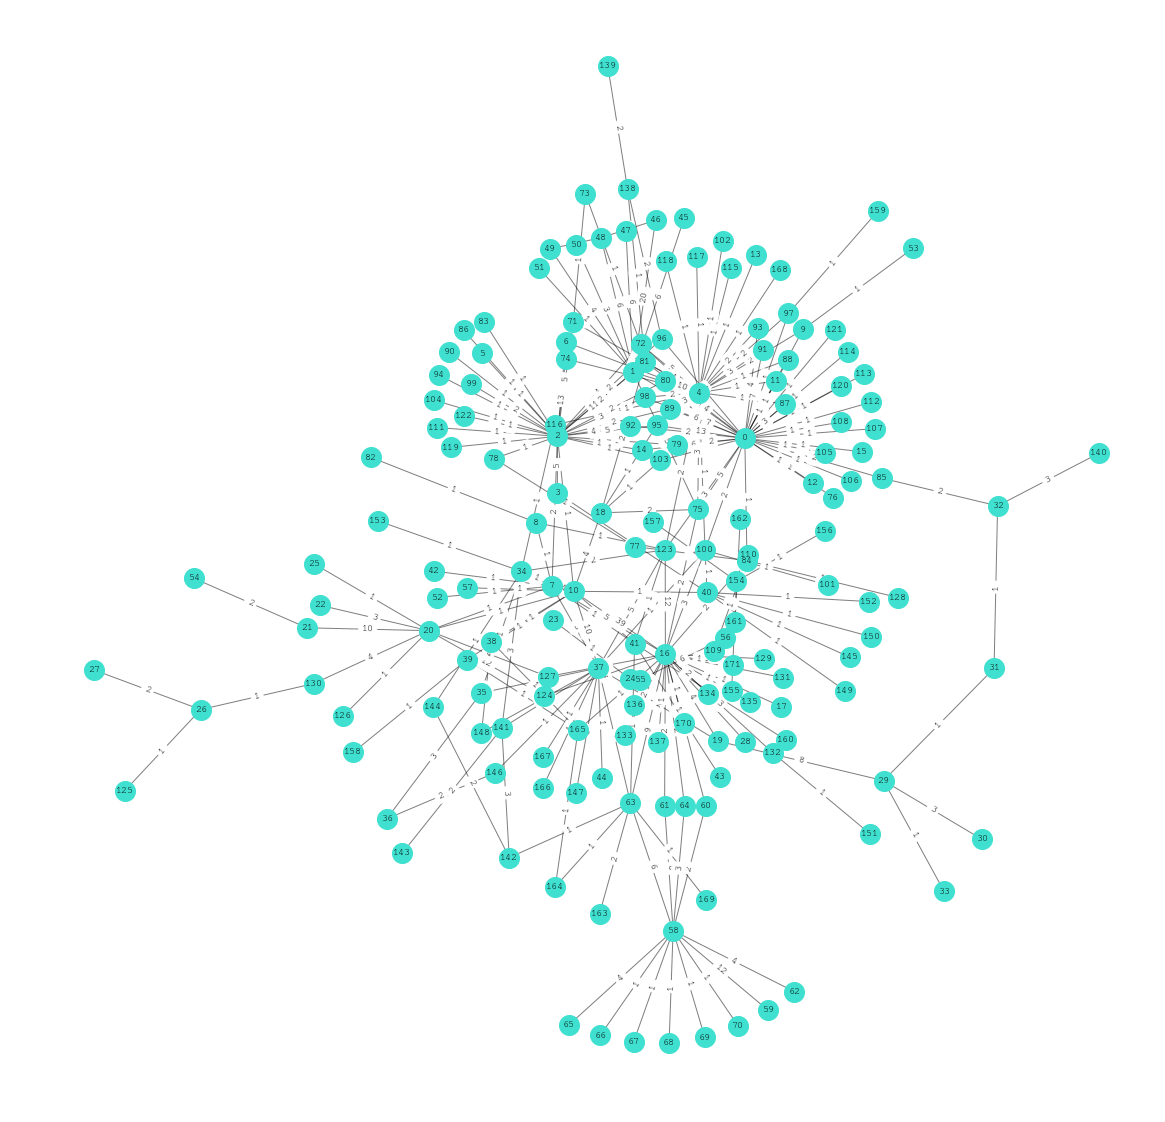

In [89]:
fig = plt.figure(figsize=(20, 20))

# nodes

nx.draw_networkx_nodes(G, pos, node_color='#40E0D0', node_size=400)

# edges
nx.draw_networkx_edges(G, pos, edgelist=edges,
                       width=1, alpha=0.5)

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family='FreeMono')

edge_labels = nx.get_edge_attributes(G,'w')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10, font_family='FreeMono', clip_on=False)

plt.axis('off')
#plt.show()
plt.savefig('ADV_graph.png', dpi=200)

In [97]:
deriv_array[1].example

'быстро'

In [96]:
deriv_array[1].wr_before

{('о', 'б'): 2,
 ('о', 'в'): 5,
 ('о', 'г'): 5,
 ('о', 'д'): 1,
 ('о', 'к'): 19,
 ('о', 'л'): 7,
 ('о', 'м'): 1,
 ('о', 'н'): 47,
 ('о', 'р'): 15,
 ('о', 'т'): 5,
 ('о', 'х'): 2,
 ('о', 'ш'): 1,
 ('о', 'щ'): 1}

In [98]:
deriv_array[1].wl_after

{('', 'а'): 1,
 ('', 'б'): 7,
 ('', 'в'): 5,
 ('', 'г'): 4,
 ('', 'д'): 13,
 ('', 'е'): 1,
 ('', 'ж'): 4,
 ('', 'з'): 2,
 ('', 'к'): 4,
 ('', 'л'): 1,
 ('', 'м'): 10,
 ('', 'н'): 7,
 ('', 'о'): 4,
 ('', 'п'): 12,
 ('', 'р'): 6,
 ('', 'с'): 15,
 ('', 'т'): 6,
 ('', 'у'): 2,
 ('', 'х'): 4,
 ('', 'ч'): 2,
 ('', 'ш'): 1}